# CNN 實作 Kaggle 貓狗影像辨識 PyTorch

## Reference

- https://medium.com/jimmyfu87/cnn%E5%AF%A6%E4%BD%9Ckaggle%E8%B2%93%E7%8B%97%E5%BD%B1%E5%83%8F%E8%BE%A8%E8%AD%98-pytorch-26380b357a3d

- https://stackoverflow.com/questions/59013109/runtimeerror-input-type-torch-floattensor-and-weight-type-torch-cuda-floatte

## Data

- Kaggle的貓狗資料集 : https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition


# Library

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets ,models, transforms
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.nn import Linear, ReLU, CrossEntropyLoss, Conv2d, MaxPool2d, Module
from torch.optim import Adam
import pandas as pd
import os
from os import listdir
# from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm
from PIL import Image

# 準備資料、設定超參數

Path_train填入自己的資料夾路徑，train 裡面有 dog 和 cat 的資料夾，分別有各 12500 張圖，並設定 Batch 和 Learning Rate。

transforms 函數可以將圖片轉成(224,224)的像素，同時將圖片轉成 PyTorch 能讀取的 tensor 格式。

In [2]:
# PATH_train = "...../train"
# ./data/train
PATH_train = "./data/train"
TRAIN = Path(PATH_train)
# Batch：每批丟入多少張圖片
batch_size = 8
# Learning Rate：學習率
LR = 0.0001
transforms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])


## 指令

```
tree -f -L 3
```

## 目錄

```
(base) kan@kan-MS-7E07:~/new-test/cd-test/cd-proj$ tree -f -L 3
.
├── ./cats-and-dogs.ipynb
├── ./data
│   └── ./data/train
│       ├── ./data/train/cat
│       └── ./data/train/dog
├── ./README.md
└── ./save

5 directories, 2 files
```

# 切分訓練驗證集

用 ImageFolder 讀取檔案並套入前面 transforms 的轉換函數， ImageFolder 會把圖片根據資料夾給予 label，可以用 class_to_idx 查詢貓和狗分別對應的 label，print出來的結果會像這樣。

```
{‘cat’: 0, ‘dog’: 1}
```

> 注意 ImageFolder 必須在資料夾內有子資料夾才可使用，所以要先分別把貓和狗的圖放進 cat 和 dog 的資料夾。

In [3]:
train_data = datasets.ImageFolder(TRAIN, transform=transforms)
# print(train_data.class_to_idx)
# 切分 70% 當作訓練集、30% 當作驗證集
train_size = int(0.7 * len(train_data))
valid_size = len(train_data) - train_size
train_data, valid_data = torch.utils.data.random_split(train_data, [train_size, valid_size])
# Dataloader 可以用 Batch 的方式訓練
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,shuffle=True)

# 建立CNN的架構

這邊要定義自己的 CNN 架構，我用最簡單的範例，基本上 CNN 最主要就是 Convolutional 和 Maxpool 兩種層所組成，Relu 是激發函數，然後最後要用線性層輸出預測結果，因為貓狗是兩個種類，所以 Linear 後面的參數就是 2，輸出結果如[0.487,0.9527]，index為 1 的狗比較大，代表預測結果為狗。

最後也可以加一層 Softmax 讓兩者機率加起來為 1 如[0.7,0.3])

PyTorch 最少要定義兩個 function，一個是 __init__，用來建立你 forward 需要用到哪些層，另一個是 forward，也就是定義路徑要怎麼走，不需另外定義 Backward，PyTorch 會自動幫你設定 Back-propagation 的路徑。

## 參數的設定

- self.cnn1=nn.Conv2d(3,16,kernal_size=5,stride=1)

3 代表input的channel，因為圖片是RGB所以是3，16代表output的channel，這邊我用了16個hidden node所以為16，kernel_size是5*5的filter。

- self.maxpool1 = nn.MaxPool2d(kernel_size=2)

這裡的kernel_size代表2*2的格子取最大的一格，會將8*8縮成4*4。

- self.fc = nn.Linear(8 * 50 * 50, 2)

至於線性層為何是(8*50*50,2)，根據下面這個公式算出下一層的shape，如原圖是(3,224,224)經過cnn1後，(224–5+1)/(1+1)=110，因此maxpool1的input就變成(16,110,110)，而Maxpool1的kernal_size為2，因此output就變成(16,55,55)，以此類推最後的Shape就變成(8*50*50,2)。

> (weight-kernel+1)/stride+1 無條件進位
 

In [4]:
class CNN_Model(nn.Module):
    # 列出需要哪些層
    def __init__(self):
        super(CNN_Model, self).__init__()
        # Convolution 1 , input_shape=(3,224,224)
        self.cnn1 = nn.Conv2d(3, 16, kernel_size=5, stride=1) 
        self.relu1 = nn.ReLU(inplace=True) 
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        # Convolution 2
        self.cnn2 = nn.Conv2d(16,8, kernel_size=11, stride=1) 
        self.relu2 = nn.ReLU(inplace=True) 
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        # Fully connected 1 ,#input_shape=(8*50*50)
        self.fc = nn.Linear(8 * 50 * 50, 2)     
    # 列出 forward 的路徑，將 init 列出的層代入
    def forward(self, x):
        out = self.cnn1(x) 
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1) 
        out = self.fc(out) 
        return out

# 定義訓練過程、計算 Loss、Accuracy

這邊先將訓練、驗證模組化，傳入的函數包含model(要使用的模型)、n_epochs(迭代次數)、train_loader、valid_loader(訓練、驗證集)、optimizer(優化器)、Criterion(損失函數)。

1. train_loss和valid loss 是算出每個 batch 的平均 loss
2. tqdm 可以很好的跟data製作出進度條(如上圖)
3. model.eval() 會關閉 batchnorm 、 dropout ，雖這範例沒有，但一般都會用到
4. output.data.max 用來輸出較大的 index 如[0.487,0.9527]，則輸出1 P
5. Validation 階段不需做 BP，所以少了幾步

In [5]:
train_on_gpu = torch.cuda.is_available()
print('Pytorch CUDA:', torch.cuda.is_available())
def train(model, n_epochs, train_loader, valid_loader, optimizer, criterion):
    train_acc_his,valid_acc_his=[],[]
    train_losses_his,valid_losses_his=[],[]
    for epoch in range(1, n_epochs+1):
        # keep track of training and validation loss
        train_loss,valid_loss = 0.0,0.0
        train_losses,valid_losses=[],[]
        train_correct,val_correct,train_total,val_total=0,0,0,0
        train_pred,train_target=torch.zeros(8,1),torch.zeros(8,1)
        val_pred,val_target=torch.zeros(8,1),torch.zeros(8,1)
        count=0
        count2=0
        print('running epoch: {}'.format(epoch))
        ###################
        # train the model #
        ###################
        model.train()
        for data, target in tqdm(train_loader):
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            #calculate accuracy
            pred = output.data.max(dim = 1, keepdim = True)[1]
            train_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            train_total += data.size(0)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_losses.append(loss.item()*data.size(0))
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            if count==0:
                train_pred=pred
                train_target=target.data.view_as(pred)
                count=count+1
            else:
                train_pred=torch.cat((train_pred,pred), 0)
                train_target=torch.cat((train_target,target.data.view_as(pred)), 0)
        train_pred=train_pred.cpu().view(-1).numpy().tolist()
        train_target=train_target.cpu().view(-1).numpy().tolist()
        ######################    
        # validate the model #
        ######################
        model.eval()
        for data, target in tqdm(valid_loader):
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            print(model(data))
            # calculate the batch loss
            loss =criterion(output, target)
            #calculate accuracy
            pred = output.data.max(dim = 1, keepdim = True)[1]
            val_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            val_total += data.size(0)
            valid_losses.append(loss.item()*data.size(0))
            if count2==0:
                val_pred=pred
                val_target=target.data.view_as(pred)
                count2=count+1
            else:
                val_pred=torch.cat((val_pred,pred), 0)
                val_target=torch.cat((val_target,target.data.view_as(pred)), 0)
        val_pred=val_pred.cpu().view(-1).numpy().tolist()
        val_target=val_target.cpu().view(-1).numpy().tolist()
        
        # calculate average losses
        train_loss=np.average(train_losses)
        valid_loss=np.average(valid_losses)
        
        # calculate average accuracy
        train_acc=train_correct/train_total
        valid_acc=val_correct/val_total
        train_acc_his.append(train_acc)
        valid_acc_his.append(valid_acc)
        train_losses_his.append(train_loss)
        valid_losses_his.append(valid_loss)
        # print training/validation statistics 
        print('\tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            train_loss, valid_loss))
        print('\tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
            train_acc, valid_acc))
    return train_acc_his,valid_acc_his,train_losses_his,valid_losses_his,model

Pytorch CUDA: True


# 開始訓練
首先初始化 CNN_Model()，使用最常用的 Adam 作為 Optimizer，由於是分類問題 Loss Function 選用 CrossEntropy，代入函數即可以開始訓練。

In [6]:
model1 = CNN_Model()
if torch.cuda.is_available():
    model1.cuda()
n_epochs = 10
optimizer1 = torch.optim.Adam(model1.parameters(), lr=LR)
criterion = CrossEntropyLoss()
train_acc_his,valid_acc_his,train_losses_his, valid_losses_his, model1 = train(model1, n_epochs, train_loader, valid_loader, optimizer1, criterion)

running epoch: 1


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

tensor([[-0.1117,  0.0591],
        [ 0.2056, -0.1994],
        [-0.1611,  0.1838],
        [ 0.5337, -0.5488],
        [ 0.3005, -0.3027],
        [-0.3487,  0.3745],
        [ 0.2293, -0.2649],
        [-1.4419,  1.3961]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0864,  0.0820],
        [ 0.3110, -0.2958],
        [-0.2346,  0.1200],
        [ 0.1865, -0.1573],
        [ 0.2252, -0.2527],
        [ 0.4734, -0.4737],
        [ 0.3215, -0.3433],
        [ 0.1949, -0.1634]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 0.3282, -0.3268],
        [ 0.3721, -0.4589],
        [ 0.1118, -0.0787],
        [-0.2780,  0.2807],
        [-0.3381,  0.3629],
        [-0.1605,  0.1652],
        [-0.1471,  0.1398],
        [-0.0930,  0.0859]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 0.2496, -0.3138],
        [-0.0136,  0.0369],
        [ 0.2419, -0.2499],
        [-0.3070,  0.3210],
        [-0.3562,  0.3311],
        [ 0.1789, -0.1515],
        [-0.2484,  0.2963],


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

tensor([[ 0.1263, -0.0869],
        [ 0.3454, -0.3636],
        [ 1.0449, -1.0265],
        [-0.6310,  0.6784],
        [-0.0460,  0.0835],
        [-1.3690,  1.2654],
        [ 0.2446, -0.1750],
        [ 0.2127, -0.2066]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 0.2846, -0.2769],
        [ 0.5998, -0.5906],
        [-0.0548,  0.1514],
        [-0.6621,  0.7048],
        [-1.0113,  1.1485],
        [-0.9695,  0.9299],
        [-0.5295,  0.5769],
        [-1.8001,  1.9237]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 0.7304, -0.7199],
        [ 0.1600, -0.1480],
        [-0.3720,  0.2339],
        [ 0.9600, -0.9670],
        [-0.2728,  0.2066],
        [-0.3690,  0.3974],
        [ 0.1200, -0.1389],
        [-0.2273,  0.0582]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 0.8423, -0.8325],
        [ 0.4676, -0.4086],
        [-0.7690,  0.7608],
        [ 0.6411, -0.5884],
        [ 0.1831, -0.2045],
        [ 0.1346, -0.1891],
        [ 0.0599, -0.0409],


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

tensor([[ 0.5195, -0.6135],
        [-0.1083, -0.0038],
        [-0.4957,  0.5502],
        [-1.2860,  1.3352],
        [ 0.1121, -0.0543],
        [-0.3741,  0.3871],
        [-0.4778,  0.5280],
        [-0.2779,  0.3665]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.4896,  0.5091],
        [ 0.4933, -0.5688],
        [ 0.3813, -0.3182],
        [-2.8101,  2.7625],
        [-0.1880,  0.1825],
        [-0.5408,  0.5373],
        [-1.1906,  1.2436],
        [-0.9477,  0.8378]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.7118,  0.6848],
        [-0.1195,  0.1368],
        [ 0.8340, -0.8870],
        [-2.5138,  2.4856],
        [ 0.0304, -0.1462],
        [-2.1706,  2.2054],
        [-0.3209,  0.3609],
        [-0.2909,  0.3030]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-5.3390e-01,  5.7867e-01],
        [-2.2519e-02,  5.8996e-02],
        [-4.1180e-01,  3.6263e-01],
        [-3.5650e-02,  2.1465e-03],
        [-6.2004e-02,  1.0274e-01],
        [-1.0991

  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

tensor([[ 0.9278, -0.8963],
        [-0.4384,  0.4548],
        [ 0.0562, -0.0091],
        [ 1.1864, -1.2196],
        [-0.7299,  0.7923],
        [ 0.0457,  0.0247],
        [ 0.9993, -0.9411],
        [ 1.3525, -1.2837]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 0.3093, -0.3710],
        [-0.9048,  0.9362],
        [ 1.0136, -0.9525],
        [ 0.2252, -0.1764],
        [ 0.8273, -0.8427],
        [-2.5551,  2.5560],
        [-0.8030,  0.8282],
        [-0.2273,  0.2521]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 1.2317, -1.1989],
        [-0.5343,  0.5096],
        [-0.7198,  0.7287],
        [ 0.6758, -0.6690],
        [ 0.7185, -0.7518],
        [ 0.9996, -1.0859],
        [-0.1268,  0.1381],
        [-0.2152,  0.2196]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 0.4999, -0.4930],
        [ 0.4660, -0.5648],
        [-0.1773,  0.2146],
        [ 0.9375, -0.8426],
        [-0.2760,  0.2874],
        [ 0.0333, -0.0070],
        [-0.6466,  0.6170],


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

tensor([[-2.2263,  2.1895],
        [ 0.5221, -0.4860],
        [-0.8421,  0.9243],
        [-1.2738,  1.2007],
        [ 0.0040,  0.1064],
        [-0.0319, -0.0035],
        [ 1.0966, -1.1958],
        [-1.9866,  2.0806]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-1.2896,  1.2670],
        [-0.3308,  0.3856],
        [-0.0483,  0.0452],
        [ 0.4106, -0.3947],
        [-1.5487,  1.5023],
        [-1.4978,  1.5573],
        [-2.2772,  2.2458],
        [ 0.3790, -0.3585]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 0.2499, -0.2257],
        [-1.0823,  1.0366],
        [ 1.5232, -1.4748],
        [ 0.7523, -0.7770],
        [-1.1504,  1.1685],
        [-0.5788,  0.5859],
        [-0.6731,  0.5679],
        [-0.7709,  0.7491]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 1.1478, -1.1269],
        [-2.3213,  2.3922],
        [ 0.0256,  0.0591],
        [-0.2349,  0.2237],
        [ 0.9300, -1.0324],
        [-0.3016,  0.3175],
        [ 0.4514, -0.4945],


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

tensor([[ 1.0050, -0.9639],
        [-0.2159,  0.2680],
        [ 1.2637, -1.3259],
        [ 1.0222, -1.0802],
        [ 0.4696, -0.4372],
        [-0.2688,  0.3591],
        [-0.1519,  0.1783],
        [-0.1327,  0.1540]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 0.5182, -0.5678],
        [-1.2830,  1.0924],
        [ 0.5217, -0.4939],
        [-2.5725,  2.6740],
        [ 0.1885, -0.2176],
        [-0.0563,  0.0882],
        [-0.2298,  0.2769],
        [-1.0042,  0.9856]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-2.2025,  2.0947],
        [-0.4916,  0.4353],
        [-1.1434,  1.1693],
        [-0.2195,  0.2486],
        [ 0.8179, -0.8580],
        [-0.6836,  0.7576],
        [ 0.7013, -0.7917],
        [ 0.4926, -0.4738]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 0.6451, -0.4991],
        [-0.2154,  0.2394],
        [ 0.9291, -1.0755],
        [ 0.1960, -0.1728],
        [ 0.9093, -0.8584],
        [ 1.0307, -1.0854],
        [-1.1688,  1.1827],


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

tensor([[ 0.7408, -0.7204],
        [ 0.5259, -0.4952],
        [-1.0903,  1.1921],
        [ 1.4323, -1.3094],
        [ 0.1016, -0.1363],
        [-0.1484,  0.0974],
        [ 0.5512, -0.5431],
        [-0.0963,  0.1467]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 1.1098, -0.9875],
        [ 0.5697, -0.6198],
        [ 1.1100, -1.0840],
        [ 0.3402, -0.2941],
        [-1.5953,  1.6755],
        [-1.6516,  1.6188],
        [ 0.3781, -0.3671],
        [ 0.4445, -0.4528]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 1.1354, -1.1206],
        [-1.0086,  1.0006],
        [ 1.1998, -1.2353],
        [-1.4956,  1.5183],
        [-1.1237,  1.0136],
        [-0.1467,  0.1044],
        [-0.9884,  0.9843],
        [ 1.4488, -1.3242]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 0.3975, -0.3633],
        [-0.4965,  0.5003],
        [ 0.5114, -0.4665],
        [-1.6862,  1.7392],
        [-1.0210,  1.0062],
        [ 1.4491, -1.5509],
        [ 0.7934, -0.8198],


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

tensor([[-0.0062, -0.1108],
        [ 0.1109,  0.1175],
        [ 1.4242, -1.5133],
        [ 1.2082, -1.2249],
        [ 1.4617, -1.4206],
        [ 1.0587, -1.0260],
        [ 0.3662, -0.3458],
        [ 2.1654, -2.1811]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 0.6495, -0.7572],
        [ 0.1316, -0.1140],
        [-1.3927,  1.3816],
        [ 0.9215, -0.8843],
        [ 1.6245, -1.6130],
        [-1.9618,  1.9618],
        [-0.1487,  0.1956],
        [ 0.0306, -0.1261]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 1.2498, -1.3781],
        [-0.1275,  0.1751],
        [-0.6964,  0.6884],
        [ 0.2016, -0.1907],
        [-1.5374,  1.4775],
        [-1.2864,  1.2823],
        [ 0.2106, -0.1306],
        [ 1.1988, -1.2708]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0052,  0.0980],
        [ 1.8167, -1.6710],
        [-1.0105,  1.0095],
        [-0.6186,  0.5765],
        [ 0.1680, -0.1720],
        [-0.4184,  0.3562],
        [-1.0157,  0.9717],


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

tensor([[-1.5671,  1.6854],
        [ 0.0731, -0.0207],
        [-2.8511,  2.8430],
        [ 1.0944, -1.0910],
        [ 0.2212, -0.2742],
        [-1.0674,  1.0297],
        [ 0.0796, -0.2831],
        [ 2.2042, -2.3114]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 0.3328, -0.4973],
        [-2.8335,  2.7342],
        [-1.1650,  1.2415],
        [-0.1723,  0.1254],
        [-2.9582,  3.0421],
        [-0.3326,  0.2901],
        [ 0.7105, -0.7463],
        [-1.7596,  1.8522]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.9549,  0.9904],
        [ 0.5722, -0.6073],
        [ 0.5861, -0.6166],
        [ 0.0296, -0.0988],
        [ 0.6604, -0.6638],
        [ 0.2707, -0.4377],
        [-0.7801,  0.8058],
        [ 1.1774, -1.1996]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-1.6327,  1.6360],
        [-2.4685,  2.3557],
        [ 1.0464, -1.1240],
        [-1.7008,  1.6341],
        [ 0.9065, -0.9079],
        [-2.7135,  2.6244],
        [-2.7830,  2.7048],


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

tensor([[-1.5499,  1.5134],
        [ 2.1346, -2.3364],
        [-0.2744,  0.2837],
        [-1.2260,  1.2348],
        [-0.1039,  0.1970],
        [-0.4429,  0.4583],
        [ 1.1358, -1.0375],
        [ 1.5887, -1.7061]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.6689,  0.4666],
        [-1.0874,  1.1422],
        [-1.1802,  1.2485],
        [-0.6068,  0.5015],
        [ 0.7129, -0.6627],
        [-0.6347,  0.4844],
        [ 1.0066, -1.0607],
        [-3.6068,  3.4141]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 1.4272, -1.5614],
        [ 0.3167, -0.4878],
        [-0.1115,  0.0922],
        [ 0.2859, -0.2381],
        [ 1.1999, -1.1530],
        [ 1.9515, -1.8765],
        [ 1.0951, -1.3018],
        [-1.5202,  1.5175]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.7675,  0.8220],
        [-0.3533,  0.2063],
        [ 1.0894, -0.8962],
        [-2.3115,  2.4068],
        [ 1.3524, -1.2905],
        [ 0.5461, -0.5426],
        [-3.5155,  3.4299],


# 訓練結果、儲存 Model

這邊就可以把剛剛訓練完的結果留下來，並畫成 loss 和 accuracy 圖，檢驗訓練的狀況，由於訓練非常耗時間，可以用 torch.save 的函數把訓練好的 model 保存下來，之後就可以直接 load 進來用。

> 做範例示範，所以用了很簡單的架構及非常少的 data，所以從上面的圖可發現 training 和 validation 差非常遠，有非常嚴重的 Overfitting 的問題，因此之後可以再去進行調整。

原範例用貓狗各 100 張，在此用原本的貓狗數據集 12500 張進行訓練。

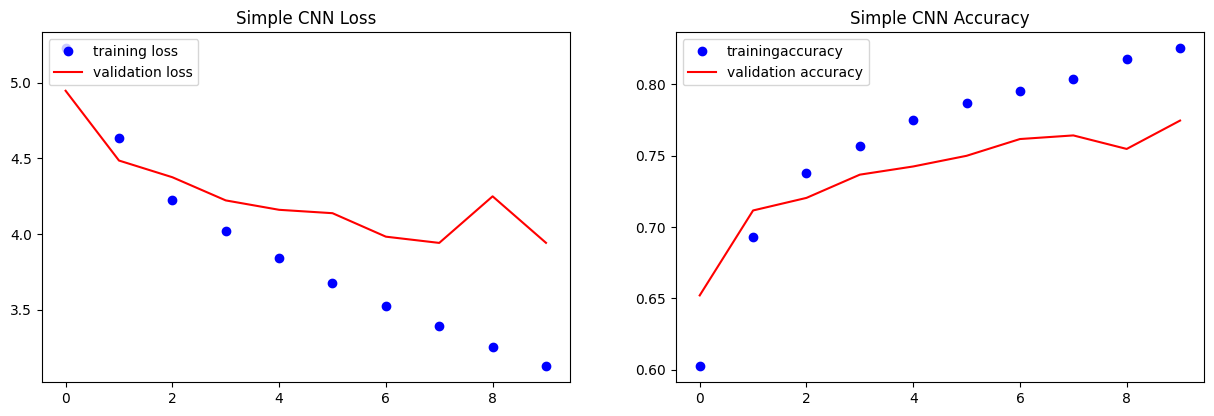

In [7]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.plot(train_losses_his, 'bo', label = 'training loss')
plt.plot(valid_losses_his, 'r', label = 'validation loss')
plt.title("Simple CNN Loss")
plt.legend(loc='upper left')
plt.subplot(222)
plt.plot(train_acc_his, 'bo', label = 'trainingaccuracy')
plt.plot(valid_acc_his, 'r', label = 'validation accuracy')
plt.title("Simple CNN Accuracy")
plt.legend(loc='upper left')
plt.show()
torch.save(model1, "save/model")
# model1 = torch.load('save/model')